# Saddle Frontend Data Graph


Visualize data sources and state in different UI flows

**Note: You'll need to have graphviz installed on your system, use `brew install graphviz` on osx**

In [346]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Set up graph, vars and config

In [347]:
common_node_attrs = {'style': 'filled', 'shape': 'box', 'colorscheme': 'pastel17'}
common_edge_attrs = {'colorscheme': 'pastel17'}
# https://graphviz.org/doc/info/colors.html#brewer
colors = {
    'contract': 1,
    'state': 2,
    'network': 3,
    'ui': 4,
    'ui_section': 4,
    'ui_page': 4,
    'actions': 5,
    'key': 'invis'
}

G = nx.DiGraph(
    splines='ortho', 
    rankdir='LR', 
#     concentrate='true',
#     newrank=True, 
    node=common_node_attrs, 
    edge=common_edge_attrs
)

def format_label(node_id):
    parts = node_id.split('_')[1:] # ignore type in 0th position
    result = []
    for part in parts:
        if part == 'sdl':
            result.append('SDL')
        elif part == 'un':
            result.append('Un /')
        elif part == 'section' or part == 'page':
            continue
        else:
            result.append(part.capitalize())
    result = ' '.join(result).strip()
    if node_id[-1] == "_":
        result += "*"
    return result

def create_nodes(ids):
    output = []
    for id in ids:
        globals()[id] = id # add node name to global vars for autocomplete later

        node_attrs = {}
        parts = id.split("_")
        node_attrs['type'] = '_'.join(parts[:2]) if parts[0] == 'ui' else parts[0]
        node_attrs['label'] = format_label(id)
#         node_attrs['label'] = ' '.join([x.capitalize() + ' /' if x == 'un' else x.capitalize() for x in parts[1:]]).strip()
        
        output.append((id, node_attrs))
    return output


# Create Nodes

In [348]:
# Contracts
G.add_nodes_from(create_nodes([
    'contract_master_registry',
    'contract_pool_registry',
    'contract_gauge_controller',
    'contract_liquidity_gauge_',
    'contract_voting_escrow',
    'contract_sdl',
    'contract_migrator',
    'contract_minichef',
    'contract_swap_',
    'contract_bridge',
    'contract_permissionless_deployer',
    'contract_erc20_',
    'contract_ext_contracts',
    'key_contract',
]), fillcolor=colors['contract'])  

# State
G.add_nodes_from(create_nodes([
    'state_pools',
    'state_tokens',
    'state_prices',
    'state_partner_rewards',
    'state_aprs',
    'state_apys',
    'state_wallet_balances',
    'state_gauges',
    'key_state',
]), fillcolor=colors['state'])

# Network
G.add_nodes_from(create_nodes([
    'network_pool_stats_api',
    'network_coingecko',
    'network_ext_apis',
    'network_subgraph',
    'key_network',
]), fillcolor=colors['network'])

# UI
G.add_nodes_from(create_nodes([
    'ui_section_swap',
    'ui_section_withdraw',
    'ui_section_deposit',
    'ui_section_pool_overview',
    'ui_section_reserves',
    'ui_section_my_farm',
    'ui_section_my_share',
    'ui_section_info',
    'ui_section_create_pool_form',
    'ui_section_wrap_sdl',
    'ui_section_vote_for_gauge',
    'ui_section_gauge_allocations',
    'ui_page_swap',
    'ui_page_pool',
    'ui_page_pool_factory',
    'ui_page_pools',
    'ui_page_gauges',
    'key_ui'
]), fillcolor=colors['ui'])

# Actions
G.add_nodes_from(create_nodes([
    'actions_swap',
    'actions_virtual_swap',
    'actions_deposit',
    'actions_withdraw',
    'actions_un_stake_in_minichef',
    'actions_migrate',
    'actions_create_pool',
    'actions_un_stake_in_gauge',
    'actions_un_wrap_sdl',
    'actions_vote_for_gauge',
    'key_actions',
]), fillcolor=colors['actions'])

legend_nodes = [key_contract, key_network, key_state, key_actions, key_ui]

# Create Edges

In [349]:
# Contract
G.add_edges_from([
    (contract_bridge, actions_virtual_swap),
    (contract_erc20_, actions_create_pool),
    (contract_erc20_, actions_un_stake_in_gauge),
    (contract_erc20_, network_subgraph),
    (contract_erc20_, state_tokens),
    (contract_erc20_, state_wallet_balances),
    (contract_ext_contracts, state_partner_rewards),
    (contract_ext_contracts, ui_section_my_share),
    (contract_gauge_controller, contract_liquidity_gauge_),
    (contract_gauge_controller, network_subgraph),
    (contract_gauge_controller, state_gauges),
    (contract_liquidity_gauge_, actions_un_stake_in_gauge),
    (contract_master_registry, contract_gauge_controller),
    (contract_master_registry, contract_permissionless_deployer),
    (contract_master_registry, contract_pool_registry),
    (contract_migrator, actions_migrate),
    (contract_migrator, state_pools),
    (contract_minichef, actions_un_stake_in_minichef),
    (contract_minichef, state_apys),
    (contract_minichef, ui_section_my_farm),
    (contract_permissionless_deployer, actions_create_pool),
    (contract_pool_registry, network_subgraph),
    (contract_pool_registry, state_pools),
    (contract_sdl, actions_un_wrap_sdl),
    (contract_swap_, actions_deposit),
    (contract_swap_, actions_swap),
    (contract_swap_, actions_withdraw),
    (contract_swap_, network_subgraph),
    (contract_voting_escrow, actions_un_wrap_sdl),
    (contract_voting_escrow, actions_vote_for_gauge),
    (contract_voting_escrow, network_subgraph),
])

# State
G.add_edges_from([
    (state_pools, state_tokens),
    (state_pools, ui_section_pool_overview),
    (state_pools, ui_section_info),
    (state_pools, ui_section_reserves),
    (state_tokens, state_prices),
    (state_tokens, state_wallet_balances),
    (state_wallet_balances, ui_section_swap),
    (state_wallet_balances, ui_section_withdraw),
    (state_wallet_balances, ui_section_deposit),
    (state_wallet_balances, ui_section_my_share),
    (state_prices, ui_section_swap),
    (state_prices, ui_section_reserves),
    (state_prices, state_aprs),
    (state_aprs, ui_section_pool_overview),
    (state_apys, ui_section_pool_overview),
    (state_partner_rewards, state_aprs),
    (state_gauges, ui_section_vote_for_gauge),
    (state_gauges, ui_section_gauge_allocations),
    (state_gauges, state_aprs),
    (state_gauges, state_apys),
])

# Network
G.add_edges_from([
    (network_coingecko, state_prices),
    (network_ext_apis, state_partner_rewards),
    (network_pool_stats_api, state_apys),
    (network_pool_stats_api, ui_section_info)
])

# Actions
G.add_edges_from([
    (actions_swap, ui_section_swap),
    (actions_virtual_swap, ui_section_swap),
    (actions_withdraw, ui_section_withdraw),
    (actions_deposit, ui_section_deposit),
    (actions_create_pool, ui_section_create_pool_form),
    (actions_un_stake_in_minichef, ui_section_my_farm),
    (actions_migrate, ui_section_pool_overview),
    (actions_un_wrap_sdl, ui_section_wrap_sdl),
    (actions_un_stake_in_gauge, ui_section_deposit),
    (actions_un_stake_in_gauge, ui_section_withdraw),
    (actions_vote_for_gauge, ui_section_vote_for_gauge),
])

# UI
G.add_edges_from([
    (ui_section_swap, ui_page_swap),
    (ui_section_info, ui_page_pool),
    (ui_section_withdraw, ui_page_pool),
    (ui_section_deposit, ui_page_pool),
    (ui_section_pool_overview, ui_page_pools),
    (ui_section_reserves, ui_page_pool),
    (ui_section_my_farm, ui_page_pool),
    (ui_section_my_share, ui_page_pool),
    (ui_section_create_pool_form, ui_page_pool_factory),
    (ui_section_wrap_sdl, ui_page_gauges),
    (ui_section_vote_for_gauge, ui_page_gauges),
    (ui_section_gauge_allocations, ui_page_gauges),
])

# Legend
nx.add_path(G, legend_nodes, style='invis')

# Draw Output

In [370]:
# G.add_edge('contract_erc20*', 'state_tokens', xlabel='\n'.join(['name', 'symbol', 'decimals']))
# all_node_types = list(set([d['type'] for _,d in G.nodes(data=True)]))
from collections import defaultdict

all_node_types = set()
for node,data in G.nodes(data=True):
    try:
        all_node_types.add(data['type'])
    except:
        raise Exception(f"Error with node: '{node}'")
all_node_types = list(all_node_types)
    
    

# Color edges
# action_section_subgraphs = defaultdict(lambda: [])
section_page_subgraphs = defaultdict(lambda: [])
for x, y, data in G.edges(data=True):
    edge_type = x.split('_')[0]
    new_data = {**data, 'color': colors[edge_type]}
#     if (x.startswith('action') and y.startswith('ui')):
#         new_data['style'] = 'invis'
#         action_section_subgraphs[y].append(x)
    if (x.startswith('ui_section') and y.startswith('ui_page')):
        new_data['style'] = 'invis'
        section_page_subgraphs[y].append(x)
    G[x][y].update(new_data)    

def generate_tree(G, target_node, save=False):
    if target_node == 'all':
        S = G
    else:
        T = nx.bfs_tree(G, target_node, reverse=True)
        S = G.subgraph([n for n in T.nodes] + legend_nodes)
    O = nx.nx_agraph.to_agraph(S)
    # Make each type into a subgraph
    # TODO: make more efficient
    for node_type in all_node_types:
        attrs = {'name': node_type}
        if node_type == 'ui_page':
            attrs['rank'] = 'max'
        elif node_type == 'ui_section':
            attrs['rank'] = 'same'
        elif node_type == 'actions':
            attrs['rank'] = 'same'
        elif node_type == 'key':
            attrs['newrank'] = True
            attrs['rankdir'] = 'LR'
            attrs['name'] = 'cluster_key'
            attrs['label'] = 'Legend'
        O.add_subgraph([n for n,d in S.nodes(data=True) if d['type'] == node_type], **attrs)
        
    # Turn PAGES into clusters of their dependent SECTIONS
    for node in section_page_subgraphs.keys():
        if target_node != 'all' and target_node != node:
            continue
        attrs = {}
        attrs['name'] = 'cluster_' + node
        attrs['rank'] = 'same'
        attrs['label'] = format_label(node)
#         attrs['color'] = 'invis' # remove bounding box
        O.remove_node(node)
        O.add_subgraph(section_page_subgraphs[node], **attrs)
        
#     # create cluster for ACTION/SECTION groups. To be refined
#     for node in action_section_subgraphs.keys():
#         attrs = {}
#         attrs['name'] = 'cluster_' + node
#         attrs['rank'] = 'same'
#         attrs['color'] = 'invis'
#         O.add_subgraph([node] + action_section_subgraphs[node], **attrs)
    
    O.layout('dot')
    if save == True:
        O.draw(f"imgs/{target_node}.png")
        O.write(f"dot/{target_node}.dot")
    return O

In [371]:
SAVE_IMAGES = True

# Gauge Flow

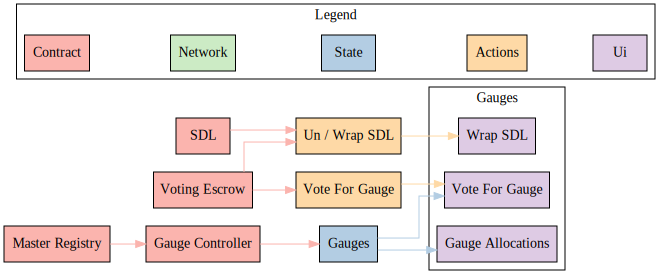

In [372]:
generate_tree(G, ui_page_gauges, save=SAVE_IMAGES)

# Swap Flow

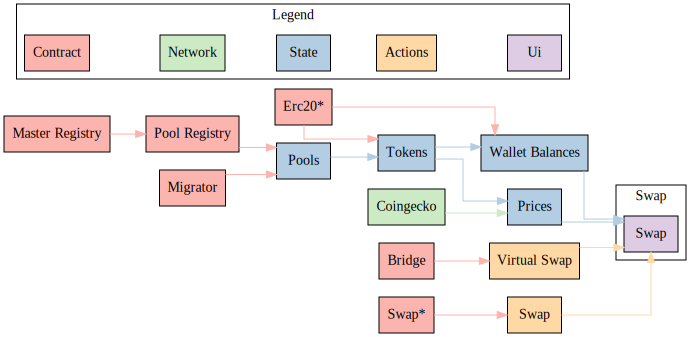

In [373]:
generate_tree(G, ui_page_swap, save=SAVE_IMAGES)

# Pools Flow

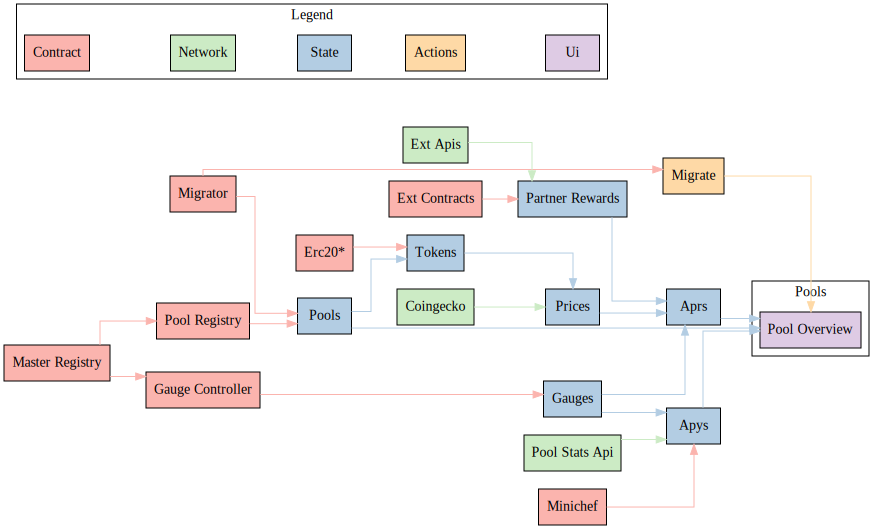

In [374]:
generate_tree(G, ui_page_pools, save=SAVE_IMAGES)


# Pool Flow

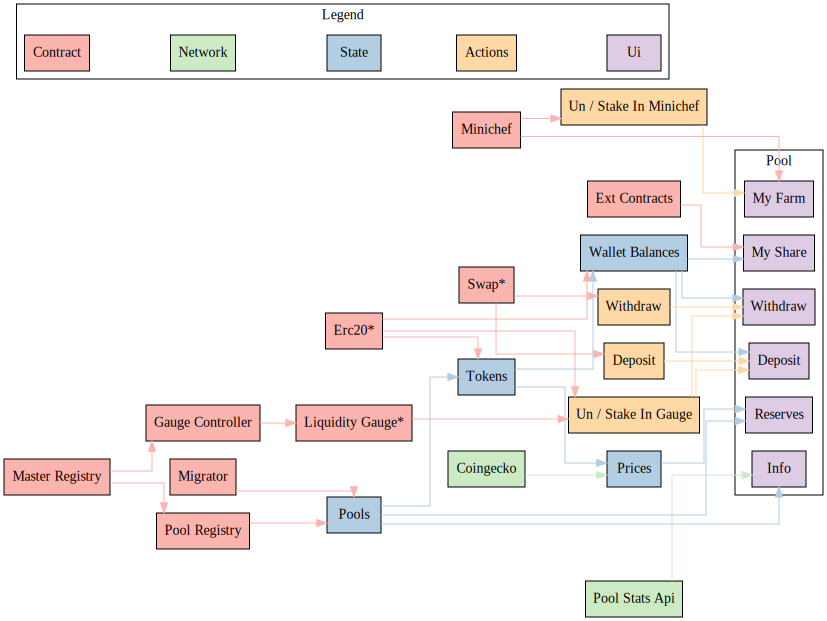

In [375]:
generate_tree(G, ui_page_pool, save=SAVE_IMAGES)

# Create Permissionless Pool Flow

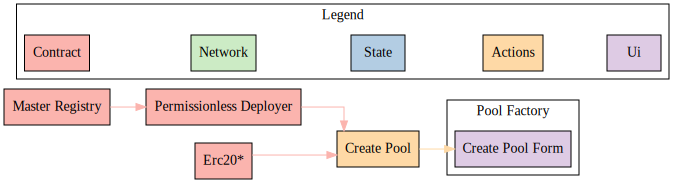

In [376]:
generate_tree(G, ui_page_pool_factory, save=SAVE_IMAGES)

# All

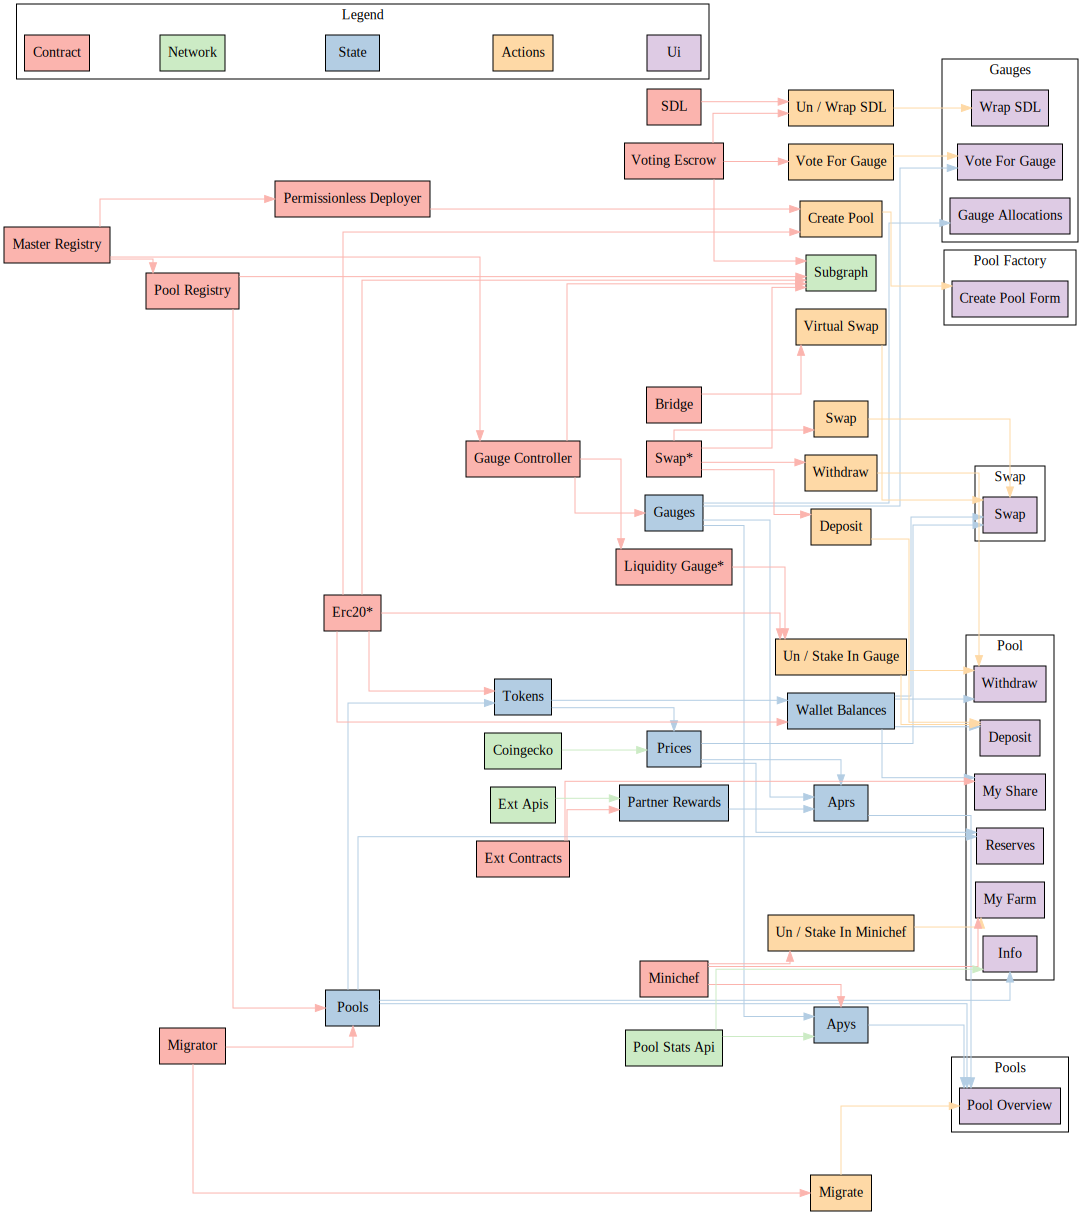

In [377]:
generate_tree(G, 'all', save=SAVE_IMAGES)